In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from msapy import plottings as pl
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
import utils as ut
import warnings
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

from neurolib.models.hopf import HopfModel
import neurolib.utils.functions as func


In [3]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

In [4]:
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
consensus_mat['LauConsensus']['Readme']

array(['1 - weighted adj mat', '2 - fiber length mat', '3 - fc mat',
       '4 - coordinates', '5{1} - roi name', '5{2} - short name',
       '5{3} - rsn name', '5{4} - hemisphere'], dtype=object)

In [20]:
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][2][0])
labels = consensus_mat['LauConsensus']['Matrices'][2][4][:,0]
human_fc = consensus_mat['LauConsensus']['Matrices'][2][2]
fiber_lengths = consensus_mat['LauConsensus']['Matrices'][2][1]

np.fill_diagonal(human_fc,0)

In [6]:
warnings.filterwarnings("ignore")
n_nodes = connectivity.shape[0]
rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02

G =0.74 #this is the optimal value based on the search below
duration = 1000
noise_strength = 0.05

noise = np.zeros((n_nodes,int(duration/delta)+1))
for i in range(int(duration/delta)+1):
    noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))

In [218]:
model = HopfModel(Cmat = connectivity, Dmat = fiber_lengths,)
model.params['sigma_ou'] = noise_strength
model.params['seed'] = SEED
model.params['duration'] = 20 * 1000 
model.params

MainProcess root INFO     hopf: Model initialized.


{'dt': 0.1,
 'duration': 20000,
 'seed': 2023,
 'coupling': 'diffusive',
 'signalV': 20.0,
 'K_gl': 0.6,
 'Cmat': array([[0.        , 0.03882827, 0.10931684, ..., 0.        , 0.        ,
         0.        ],
        [0.03882827, 0.        , 0.19985202, ..., 0.        , 0.        ,
         0.        ],
        [0.10931684, 0.19985202, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.18992471,
         0.05838138],
        [0.        , 0.        , 0.        , ..., 0.18992471, 0.        ,
         0.21895762],
        [0.        , 0.        , 0.        , ..., 0.05838138, 0.21895762,
         0.        ]]),
 'N': 219,
 'lengthMat': array([[ 0.        , 11.91885119, 15.63142073, ...,  0.        ,
          0.        ,  0.        ],
        [11.91885119,  0.        , 18.60829465, ...,  0.        ,
          0.        ,  0.        ],
        [15.63142073, 18.60829465,  0.        , ...,  0.        ,
  

In [219]:
rng = np.random.default_rng(seed=SEED)
hopf_parameter_space = list(ParameterGrid({'K_gl':np.linspace(0.0,8,41).round(2),
                                           'a':np.linspace(-0.25,0.25,6).round(2)}))

for parameters in tqdm(hopf_parameter_space,
                       total=len(hopf_parameter_space),
                       desc='Optimizing hyperparams: '):

    model.params['K_gl'] = parameters['K_gl']
    model.params['a'] = parameters['a']
    model.run(chunkwise=False)

    fc = func.fc(model.x)

    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = func.matrix_correlation(human_fc, fc)
        parameters.update({'correlation': r})
        
hopf_optimum_params = max(hopf_parameter_space, key=lambda x: x['correlation'])
hopf_optimum_params

Optimizing hyperparams: 100%|██████████| 246/246 [1:37:43<00:00, 23.84s/it]


{'K_gl': 5.8, 'a': 0.15, 'correlation': 0.38782217889347104}

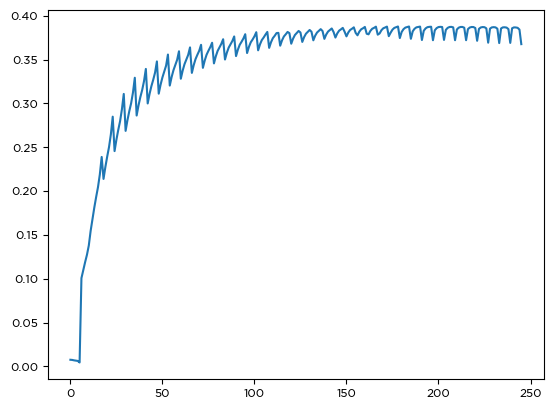

In [220]:
fit_results = []
for index,correlation in enumerate(hopf_parameter_space):
    fit_results.append(hopf_parameter_space[index]['correlation'])
plt.plot(fit_results);

In [221]:
model.params['K_gl'] = hopf_optimum_params['K_gl']
model.run(chunkwise=False)

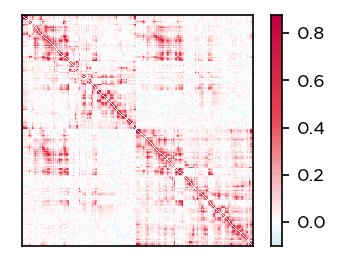

In [222]:
fc = np.corrcoef(model.x)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

MainProcess root INFO     hopf: Model initialized.


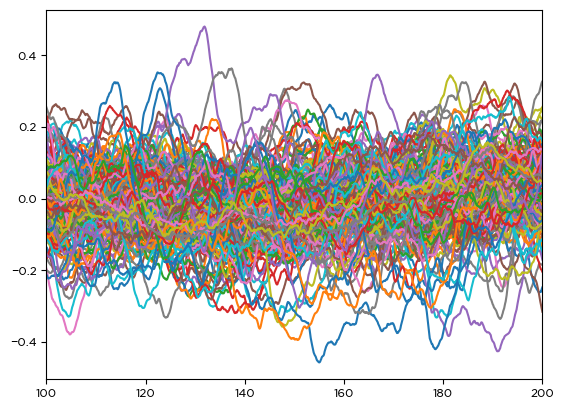

In [247]:
model = HopfModel(Cmat = connectivity, Dmat = fiber_lengths,)
model.params['sigma_ou'] = noise_strength
model.params['seed'] = SEED
model.params['duration'] = 1 * 200
model.params['K_gl'] = hopf_optimum_params['K_gl']
model.params['a'] = hopf_optimum_params['a']

model.run(chunkwise=False)
plt.plot(model.t,model.x.T)
plt.xlim(100,200);

In [244]:
lesioned_connectivity = connectivity.copy()
lesioned_connectivity[70:100,:] = 0
lesioned_connectivity[:,70:100] = 0

lesioned_delay = fiber_lengths.copy()
lesioned_delay[70:100,:] = 0
lesioned_delay[:,70:100] = 0

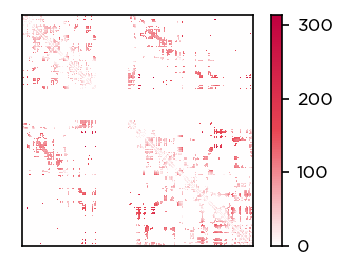

In [246]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(lesioned_delay,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

MainProcess root INFO     hopf: Model initialized.


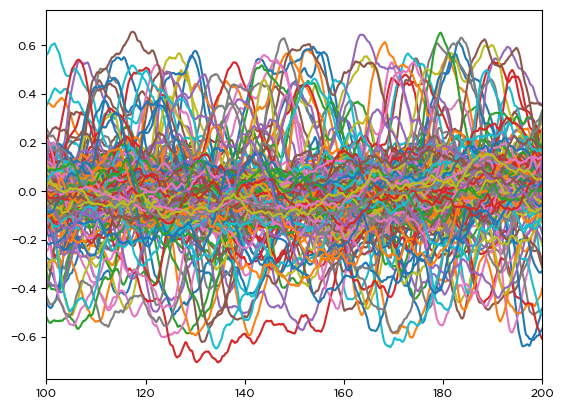

In [248]:
model = HopfModel(Cmat = lesioned_connectivity, Dmat = lesioned_delay)
model.params['sigma_ou'] = noise_strength
model.params['seed'] = SEED
model.params['duration'] = 1 * 200
model.params['K_gl'] = hopf_optimum_params['K_gl']
model.params['a'] = hopf_optimum_params['a']


model.run(chunkwise=False)
plt.plot(model.t,model.x.T)
plt.xlim(100,200);

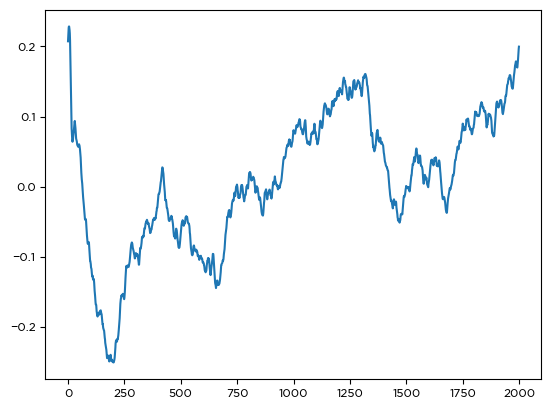

In [250]:
plt.plot(model.x[2])

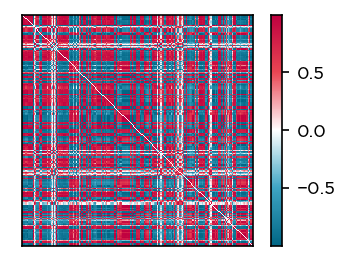

In [56]:
from kuramoto import Kuramoto, plot_activity
kumodel = Kuramoto(coupling=200, dt=0.01, T=30, n_nodes=n_nodes)
kuractivity = kumodel.run(adj_mat=connectivity)

fc = np.corrcoef(kuractivity)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);


In [132]:
rng = np.random.default_rng(seed=SEED)
kuramoto_parameter_space = list(ParameterGrid({'coupling':np.linspace(0.01,100,100).round(2,)}))
for parameters in tqdm(kuramoto_parameter_space,
                       total=len(kuramoto_parameter_space),
                       desc='Optimizing hyperparams: '):
    kumodel = Kuramoto(coupling=parameters['coupling'], dt=0.01, T=30, n_nodes=n_nodes)
    kuractivity = kumodel.run(adj_mat=connectivity)

    fc = np.corrcoef(np.sin(kuractivity))
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})
        
kuramoto_optimum_params = max(kuramoto_parameter_space, key=lambda x: x['correlation'])
kuramoto_optimum_params

Optimizing hyperparams: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


{'coupling': 97.98, 'correlation': 0.12848739309801196}

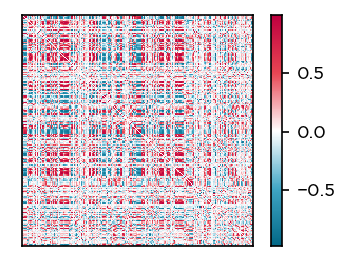

In [133]:
kumodel = Kuramoto(coupling=kuramoto_optimum_params['coupling'], dt=0.01, T=30, n_nodes=n_nodes)
kuractivity = kumodel.run(adj_mat=connectivity)

fc = np.corrcoef(np.sin(kuractivity))
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

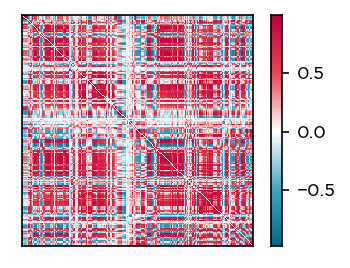

In [97]:
kuractivity = ut.kuramoto_model(adjacency_matrix=connectivity, T=40, dt=0.01, coupling=10, initial_theta=rng.uniform(0.1,2*np.pi,n_nodes),omega = rng.normal(size=n_nodes))

fc = np.corrcoef(kuractivity)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

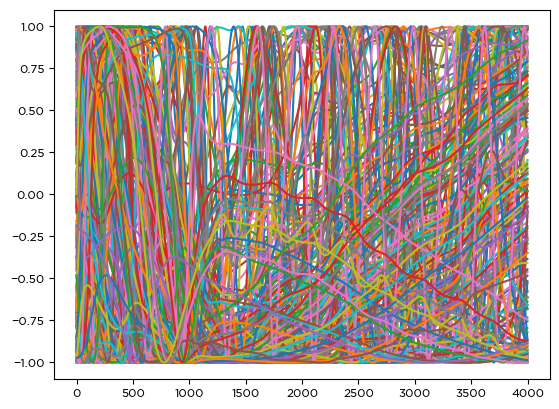

In [98]:
plt.plot(kuractivity.T);

In [104]:
rng = np.random.default_rng(seed=SEED)

kuramoto_parameter_space = list(ParameterGrid({'coupling':np.linspace(0.01,10,100).round(2,)}))
initial_theta = rng.uniform(0.1,2*np.pi,n_nodes)
omega = rng.normal(size=n_nodes)
for parameters in tqdm(kuramoto_parameter_space,
                       total=len(kuramoto_parameter_space),
                       desc='Optimizing hyperparams: '):
    
    kuractivity = ut.kuramoto_model(adjacency_matrix=connectivity,
                                    T=10, dt=0.01, coupling=parameters['coupling'],
                                    initial_theta=initial_theta,omega=omega)
    fc = np.corrcoef(kuractivity)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})

Optimizing hyperparams: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [105]:
kuramoto_optimum_params = max(kuramoto_parameter_space, key=lambda x: x['correlation'])
kuramoto_optimum_params

{'coupling': 7.07, 'correlation': 0.062487893640801914}

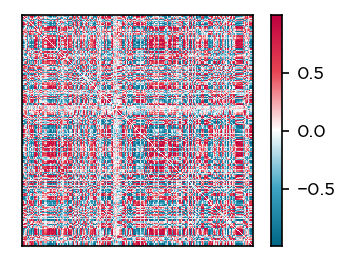

In [107]:
kuractivity = ut.kuramoto_model(adjacency_matrix=connectivity,
                                    T=10, dt=0.01, coupling=kuramoto_optimum_params['coupling'],
                                    initial_theta=initial_theta,omega=omega)

fc = np.corrcoef(kuractivity)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

In [117]:
kuractivity2 = ut.kuramoto_model(adjacency_matrix=connectivity,
                                    T=10, dt=0.01, coupling=7.08,
                                    initial_theta=initial_theta,omega=omega)

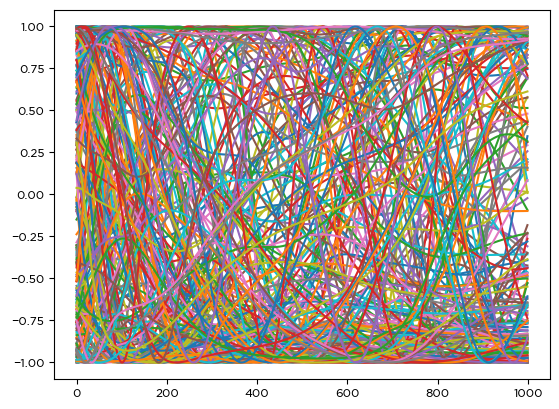

In [118]:
plt.plot(kuractivity2.T);

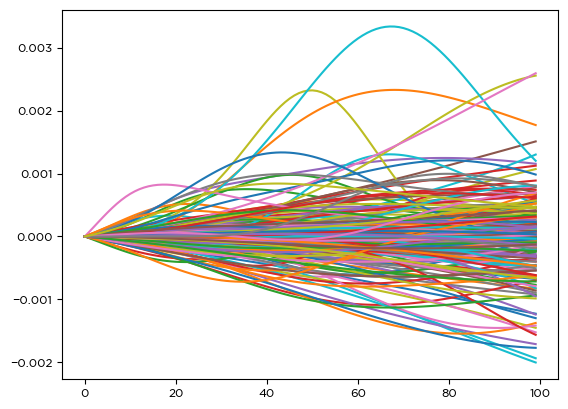

In [123]:
plt.plot((kuractivity.T-kuractivity2.T)[:100,:]);

In [7]:
sar_parameter_space = list(ParameterGrid({'omega':np.linspace(0.01,1.,20).round(2,)}))

In [8]:
for parameters in tqdm(sar_parameter_space,
                       total=len(sar_parameter_space),
                       desc='Optimizing hyperparams: '):
    fc = ut.sar_model(adjacency_matrix=connectivity, omega=parameters['omega'])
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


In [9]:
sar_optimum_params = max(sar_parameter_space, key=lambda x: x['correlation'])
sar_optimum_params

{'omega': 0.27, 'correlation': 0.2628972048083315}

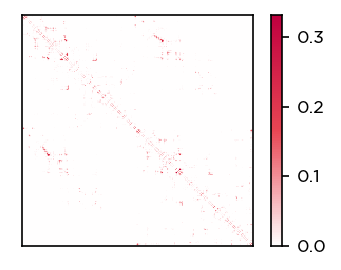

In [10]:
fc = ut.sar_model(adjacency_matrix=connectivity, omega=sar_optimum_params['omega'])
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

In [11]:
simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,coupling=G,dt=delta,timeconstant=tau,input_matrix=noise,duration=duration)

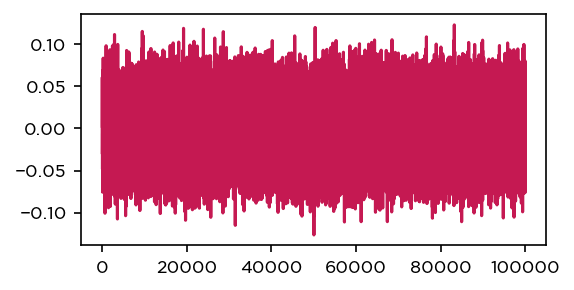

In [12]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_human_dynamics[10],alpha=0.9,color=RED);
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0)
fc = np.nan_to_num(fc)

0.23416942950163153

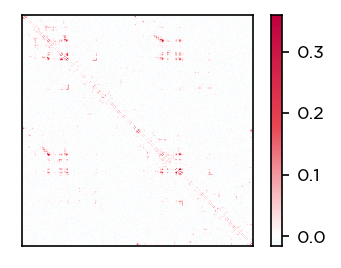

In [13]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);
np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]

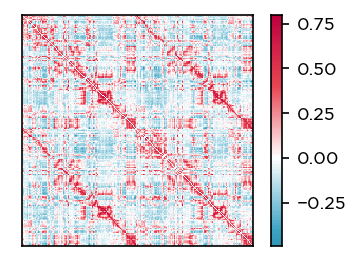

In [14]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(human_fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

In [15]:
parameter_space = list(ParameterGrid({'G':np.linspace(0.01,1.,20).round(2,)}))

In [16]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                    coupling=parameters['G'],
                                    dt=delta,
                                    timeconstant=tau,
                                    input_matrix=noise,
                                    duration=duration)
    
    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 20/20 [03:56<00:00, 11.84s/it]


In [18]:
optimum_params = max(parameter_space, key=lambda x: x['correlation'])
dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                    coupling=optimum_params['G'],
                                    dt=delta,
                                    timeconstant=tau,
                                    input_matrix=noise,
                                    duration=duration)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc,0)
optimum_params

{'G': 0.74, 'correlation': 0.23416942950163153}

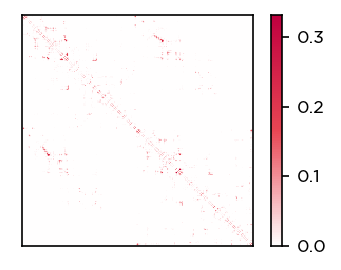

In [ ]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

In [19]:
fit_results = []
for index,correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]['correlation'])

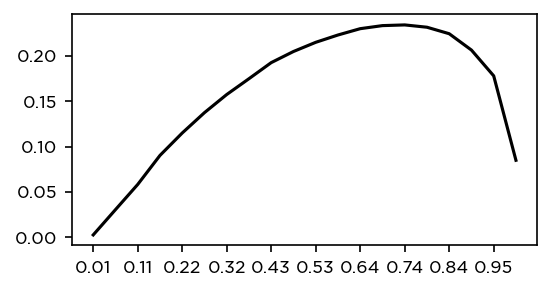

In [21]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(fit_results,color='k')
plt.xticks(np.arange(0,20,2),np.linspace(0.01,1.,20).round(2,)[::2]);